# Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time

Define some key model parameters (will get used but defined here up top for convenience).

In [3]:
period_length = 10
max_age =  1000

In [4]:
# Input paths
vdyp_curves_smooth_tsa04_path = './data/vdyp_curves_smooth-tsa04.feather'

# Output paths
stands_csv_path = './data/stands.csv'

stands_mdf_csv_path = './data/stands_mdf.csv'

yld_vdyp_csv_path = './data/yld_vdyp.csv'

yldmerged_csv_path = './data/yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files/tsa04.lan'
woodstock_model_files_are_path = './data/woodstock_model_files/tsa04.are'
woodstock_model_files_yld_path = './data/woodstock_model_files/_tsa04.yld'
woodstock_model_files_act_path = './data/woodstock_model_files/tsa04.act'
woodstock_model_files_trn_path = './data/woodstock_model_files/tsa04.trn'

# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents a small subset of timber supply area (TSA) 17 in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [5]:
Start = time.time()
stands = gpd.read_file('data/tsa04contclass/tsa04.shp')
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 11.9 minutes to run this script.


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [6]:
canfi_map = {'AC':1211, 
             'AT':1201, 
             'BL':304, 
             'EP':1303, 
             'FDI':500, 
             'HW':402,
             'HM':403,
             'PL':204, 
             'PLI':204, 
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'S':100,
            'AT+SX':1201,
            'SX+AT':100}

In [7]:
Aspen = ['AC', 'ACT', 'AT', 'EP', 'VB', 'MB', 'AT+SX']
Bal = ['B', 'BA', 'BG', 'BL']
Cedar = ['CW', 'YC']
Alder = ['D', 'DR']
DougFir = ['F', 'FD', 'FDC', 'FDI']
Hem = ['H', 'HM', 'HW']
Pine = ['PA', 'PL', 'PLC', 'PW', 'PLI', 'PY']
Spruce = ['S', 'SS', 'SW', 'SX', 'SE', 'SXW', 'SB', 'SX+AT']

In [ ]:
au_table_data = {'au_id':[],
                 'tsa':[],
                 'stratum_code':[],
                 'si_level':[],
                 'canfi_species':[],
                 'unmanaged_curve_id':[],
                 'managed_curve_id':[]} 

curve_table_data = {'curve_id':[],
                    'curve_type':[]}

curve_points_table_data = {'curve_id':[],
                           'x':[],
                           'y':[]}

for tsa in ria_tsas:
    print(tsa)
    vdyp_curves_ = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level'])
    tipsy_curves_ = tipsy_curves[tsa].reset_index().set_index('AU')
    for stratum_code, si_level in list(vdyp_curves_.index.unique()):
        au_id_ = scsi_au[tsa][(stratum_code, si_level)]
        tipsy_curve_id = 20000 + au_id_
        is_managed_au = tipsy_curve_id in tipsy_curves_.index.unique()
        au_id = 100000 * int(tsa) + au_id_
        unmanaged_curve_id = au_id
        managed_curve_id = au_id + 20000 if is_managed_au else unmanaged_curve_id
        #print(au_id, stratum_code, si_level, is_managed_au, unmanaged_curve_id, managed_curve_id)
        au_table_data['au_id'].append(au_id)
        au_table_data['tsa'].append(tsa)
        au_table_data['stratum_code'].append(stratum_code)
        au_table_data['si_level'].append(si_level)
        au_table_data['canfi_species'].append(canfi_species(stratum_code))
        au_table_data['unmanaged_curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_type'].append('unmanaged')
        vdyp_curve = vdyp_curves_.loc[(stratum_code, si_level)]
        #print('vdyp curve')
        for x, y in zip(vdyp_curve.age, vdyp_curve.volume):
            #print(x, round(y, 2))
            curve_points_table_data['curve_id'].append(unmanaged_curve_id)
            curve_points_table_data['x'].append(int(x))
            curve_points_table_data['y'].append(round(y, 2))
        au_table_data['managed_curve_id'].append(managed_curve_id)
        if is_managed_au:
            curve_table_data['curve_id'].append(managed_curve_id)
            curve_table_data['curve_type'].append('managed')        
            tipsy_curve = tipsy_curves_.loc[tipsy_curve_id]
            #print('tipsy curve')
            for x, y in zip(tipsy_curve.Age, tipsy_curve.Yield):
                #print(x, round(y, 2))
                curve_points_table_data['curve_id'].append(managed_curve_id)
                curve_points_table_data['x'].append(int(x))
                curve_points_table_data['y'].append(round(y, 2))
au_table = pd.DataFrame(au_table_data)
curve_table = pd.DataFrame(curve_table_data)
curve_points_table = pd.DataFrame(curve_points_table_data)

In [8]:
columns_to_keep = ['TSA_NUMBER', 'contclass', 'Age_2023', 'AU', 'geometry', 'SPECIES_CD']
stands_mdf = stands[columns_to_keep].copy()
stands_mdf.loc[:,'area'] = stands_mdf.geometry.area * 0.0001 # monkey-patch broken area attribute
stands_mdf =  stands_mdf.rename(columns={'TSA_NUMBER': 'theme0', 'contclass':'theme1', 'AU':'theme2', 'Age_2023':'age', 'SPECIES_CD':'species'})
stands_mdf['theme0'] = stands_mdf['theme0'].replace({'04': 'tsa04'})
stands_mdf['theme1'] = stands_mdf['theme1'].replace({'C': 1, 'N': 0})
stands_mdf = stands_mdf.drop(columns='geometry')
stands_mdf.insert(4, 'theme3',  stands_mdf['species'].map(canfi_map)) #Burn CANFI species codes into stand data
stands_mdf['theme3'] = stands_mdf['theme3'].astype(int)
stands_mdf.drop(columns=['species'], inplace=True)
stands_mdf.insert(5, 'theme4', stands_mdf['theme2']) # to be filled out with the scpecies code
stands_mdf.insert(5, 'age', stands_mdf.pop('age'))
stands_mdf

,theme0,theme1,theme2,theme3,theme4,age,area
0,tsa04,1,6,100,6,46,1.647422
1,tsa04,1,6,100,6,46,2.521410
2,tsa04,1,6,100,6,46,8.703542
3,tsa04,1,6,100,6,46,0.230573
4,tsa04,1,6,100,6,46,1.551006
...,...,...,...,...,...,...,...
63203,tsa04,0,33,1201,33,83,0.150252
63204,tsa04,0,33,1201,33,83,0.195038
63205,tsa04,0,33,1201,33,83,0.160693
63206,tsa04,0,33,1201,33,101,0.127911


Read yield data from a CSV file and recast AU column data type to integer.

In [9]:
print('whole area (ha) is:', stands_mdf['area'].sum())
print('whole contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 1]['area'].sum())
print('whole non-contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 0]['area'].sum())

whole area (ha) is: 191273.58586001678
whole contributing area (ha) is: 134732.25775766742
whole non-contributing area (ha) is: 56541.328102349355


Burn CANFI species codes into yield data tables.

In [10]:
yld_vdyp = pd.read_feather(vdyp_curves_smooth_tsa04_path)
yld_vdyp[['zone', 'species']] = yld_vdyp['stratum_code'].str.split('_', expand=True)
yld_vdyp['canfi_species'] = yld_vdyp['species'].map(canfi_map)
yld_vdyp['canfi_species'] = yld_vdyp['canfi_species'].astype(int)

In [11]:
def calculate_au(row):
    if row['species'] in Aspen:
        return 33
    elif row['species'] in Spruce and row['zone'] in ["CWH", "ESSF", "ICH", "SBS", "MH"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 2
        elif row['si_level'] == "H":
            return 1
        elif row['si_level'] == "L":
            return 3
    elif row['species'] in Spruce and row['zone'] in  ["BWBS", "SWB"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 5
        elif row['si_level'] == "H":
            return 4
        elif row['si_level'] == "L":
            return 6
    elif row['species'] in Spruce and row['zone'] in  ["BAFA", "CMA"]:
        return 7
    elif row['species'] in Pine and row['zone'] in ["CWH", "ESSF", "ICH", "SBS", "MH"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 9
        elif row['si_level'] == "H":
            return 8
        elif row['si_level'] == "L":
            return 10
    elif row['species'] in Pine and row['zone'] in ["BWBS", "SWB"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 12
        elif row['si_level'] == "H":
            return 11
        elif row['si_level'] == "L":
            return 13
    elif row['species'] in Pine and row['zone'] in ["BAFA", "CMA"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 15
        elif row['si_level'] == "H":
            return 14
        elif row['si_level'] == "L":
            return 16
    elif row['species'] in Bal  and row['zone'] in ["CWH", "ESSF", "ICH", "SBS", "MH"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 18
        elif row['si_level'] == "H":
            return 17
        elif row['si_level'] == "L":
            return 19
    elif row['species'] in Bal  and row['zone'] in ["BWBS", "SWB"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 21
        elif row['si_level'] == "H":
            return 20
        elif row['si_level'] == "L":
            return 22
    elif row['species'] in Bal  and row['zone'] in ["BAFA", "CMA"]:
        return 23
    elif row['species'] in Hem  and row['zone'] in ["CWH", "ESSF", "ICH", "SBS", "MH"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 25
        elif row['si_level'] == "H":
            return 24
        elif row['si_level'] == "L":
            return 26
    elif row['species'] in Hem  and row['zone'] in ["BWBS", "SWB"]:
        if si_level is None or si_level == "M":
            return 28
        elif si_level == "H":
            return 27
        elif si_level == "L":
            return 29
    elif row['species'] in Hem  and row['zone'] in ["BAFA", "CMA"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 30
        elif row['si_level'] == "H":
            return 30
        elif row['si_level'] == "L":
            return 31
    elif row['species'] in Hem  and row['zone'] in ["BAFA", "CMA"]:
        if row['si_level'] is None or row['si_level'] == "M":
            return 30
        elif si_level == "H":
            return 30
        elif si_level == "L":
            return 31
    # elif:
    #     return 32

In [12]:
yld_vdyp['AU'] = yld_vdyp.apply(calculate_au, axis=1)
yld_vdyp['AU'] = yld_vdyp['AU'].astype(int)
yld_vdyp

,index,age,volume,stratum_code,si_level,zone,species,canfi_species,AU
0,17,18,6.282000e-11,ESSF_BL,L,ESSF,BL,304,19
1,18,19,3.625496e-08,ESSF_BL,L,ESSF,BL,304,19
2,19,20,7.916861e-07,ESSF_BL,L,ESSF,BL,304,19
3,20,21,6.105747e-06,ESSF_BL,L,ESSF,BL,304,19
4,21,22,2.801684e-05,ESSF_BL,L,ESSF,BL,304,19
...,...,...,...,...,...,...,...,...,...
12296,294,295,9.945361e+01,BWBS_AT,H,BWBS,AT,1201,33
12297,295,296,9.878314e+01,BWBS_AT,H,BWBS,AT,1201,33
12298,296,297,9.811513e+01,BWBS_AT,H,BWBS,AT,1201,33
12299,297,298,9.744960e+01,BWBS_AT,H,BWBS,AT,1201,33


In [13]:
bec_zone_stands = stands['ZONE'].drop_duplicates()
bec_zone_stands

0        SWB
28      BWBS
388       MH
1108     SBS
1474    ESSF
2572     CWH
2812    BAFA
2916     CMA
Name: ZONE, dtype: object

In [14]:
bec_zone_vdyp = yld_vdyp['zone'].drop_duplicates()
bec_zone_vdyp

0       ESSF
861     BWBS
3472      MH
7008     SBS
Name: zone, dtype: object

In [15]:
au_stands = stands['AU'].drop_duplicates()
len(au_stands), au_stands

(28,
 0         6
 10       22
 12       13
 30       29
 56       33
 96       19
 146      10
 388      26
 412       3
 498      25
 802       7
 922      31
 1154     18
 1700     24
 1912     23
 2268      1
 2890     30
 3828     12
 4244      5
 4504     16
 5026     21
 7412      4
 12893     2
 14077    17
 27490    28
 28596    14
 28928    15
 34010    32
 Name: AU, dtype: int64)

In [16]:
au_vdyp = yld_vdyp['AU'].drop_duplicates()
len(au_vdyp), au_vdyp

(22,
 0       19
 282     18
 568     17
 861     13
 1152    12
 1444    11
 1738     6
 2022     5
 2302     4
 2586     3
 2874     2
 3173     1
 3472    26
 3771    25
 4070    24
 4364    22
 4653    21
 4937    20
 5221    33
 6111    10
 6410     9
 6709     8
 Name: AU, dtype: int64)

Create analysis unit (AU) dataframe from stands dataframe data.

In [17]:
AU = pd.DataFrame(stands_mdf['theme2']).drop_duplicates()
AU.rename(columns={'theme2':'AU'}, inplace=True)

Join `AU` and `yld_vdyp` dataframes.

In [18]:
yldmerged = pd.merge(AU, yld_vdyp, on=['AU'], how='inner')
yldmerged

,AU,index,age,volume,stratum_code,si_level,zone,species,canfi_species
0,6,15,16,8.016443e-13,BWBS_SX,L,BWBS,SX,100
1,6,16,17,2.403826e-10,BWBS_SX,L,BWBS,SX,100
2,6,17,18,6.563612e-09,BWBS_SX,L,BWBS,SX,100
3,6,18,19,6.724511e-08,BWBS_SX,L,BWBS,SX,100
4,6,19,20,4.027067e-07,BWBS_SX,L,BWBS,SX,100
...,...,...,...,...,...,...,...,...,...
11120,17,294,295,3.216543e+02,MH_BL,H,MH,BL,304
11121,17,295,296,3.206646e+02,MH_BL,H,MH,BL,304
11122,17,296,297,3.196688e+02,MH_BL,H,MH,BL,304
11123,17,297,298,3.186671e+02,MH_BL,H,MH,BL,304


In [19]:
au_yldmerged = yldmerged['AU'].drop_duplicates()
len(au_yldmerged), au_yldmerged

(18,
 0         6
 581      22
 870      13
 1161     33
 3827     19
 4693     10
 4992     26
 5291      3
 5878     25
 6177     18
 7048     24
 7342      1
 7939     12
 8231      5
 8801     21
 9085      4
 9660      2
 10249    17
 Name: AU, dtype: int64)

Add a new `curve_id` colume that has same data values as `AU` column.

In [20]:
yldmerged['curve_id'] = yldmerged['AU'] 

Save reformatted data to CSV files. 

In [21]:
stands_mdf.to_csv(stands_mdf_csv_path, index=False)
yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)

Rename stuff to match variable names we expect further down.

In [22]:
stands_table = stands_mdf
curve_points_table = yldmerged
# curve_points_table = pd.read_csv("data/yldmerged_mmdf.csv")
curve_points_table.set_index('AU', inplace=True)

# Export Woodstock-formatted input files 

We can use the new ws3 model instance we just built to export ws3 input files in Woodstock file format. We do this for three reasons. 

The first reason is that it will be simpler and more compact in the actual DSS notebook to instantiate the `ForestModel` object from these Woodstock-formatted files (and also this will provide an opportunity to demonstrate the existance and usage of the Woodstock model import functions that are built into ws3). 

The second reason is that the process of exporting data from a live `ws3.forest.ForestModel` instance to Woodstock-formatted input data files provides some insight into the internal structure and workings of ws3 models (which can be a challenging thing to get started with, particularly if you do not have a lot of experience building and running forest estate models). 

The third reason is that Woodstock file format is designed to be "human readable" (sort of... nobody ever said it would be super easy or super fun). Picking through the exported Woodstock-formatted files might help some people better understand the structure and details of the model we have built. If you have no experience reading Woodstock-formatted model input data files, then this is going to be trickier (unless you pause here and go take an introductory Woodstock training course of sort). Many forest professionals already have familiarity with Woodstock software and its special file format (through having been exposed to this at some point in their career). 

Start by creating a new subdirectory to hold the new Woodstock-formatted data files.

In [23]:
!mkdir data/woodstock_model_files

mkdir: cannot create directory ‘data/woodstock_model_files’: File exists


## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [24]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'  # yield curve ID
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))

In [25]:
with open(woodstock_model_files_lan_path, 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    print('tsa04',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [26]:
gstands = stands_table.groupby(theme_cols+['age'])

In [27]:
with open(woodstock_model_files_are_path, 'w') as file:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [28]:
with open(woodstock_model_files_yld_path, 'w') as file:
    tot=[]
    swd=[]
    hwd=[]
    unique_au_rows = curve_points_table[~curve_points_table.index.duplicated(keep='first')]    
    for AU, au_row in unique_au_rows.iterrows():
        yname = 's%04d' % int(au_row.canfi_species)    
        curve_id = au_row.curve_id
        mask = ('?', '?', str(AU), '?', str(curve_id))
        points = [(r.age, r.volume) for _, r in curve_points_table.loc[AU].iterrows() if not r.age % period_length and r.age <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask), file=file)
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 300, 10)), file=file)
        if yname not in tot:
            tot.append(yname)
        if int(au_row.canfi_species) > 1200:
            if yname not in hwd: hwd.append(yname)
        else:
            if yname not in swd: swd.append(yname)
    print('*YC ? ? ? ? ?', file=file)
    print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
    print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
    print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

(0.0, 300.0)

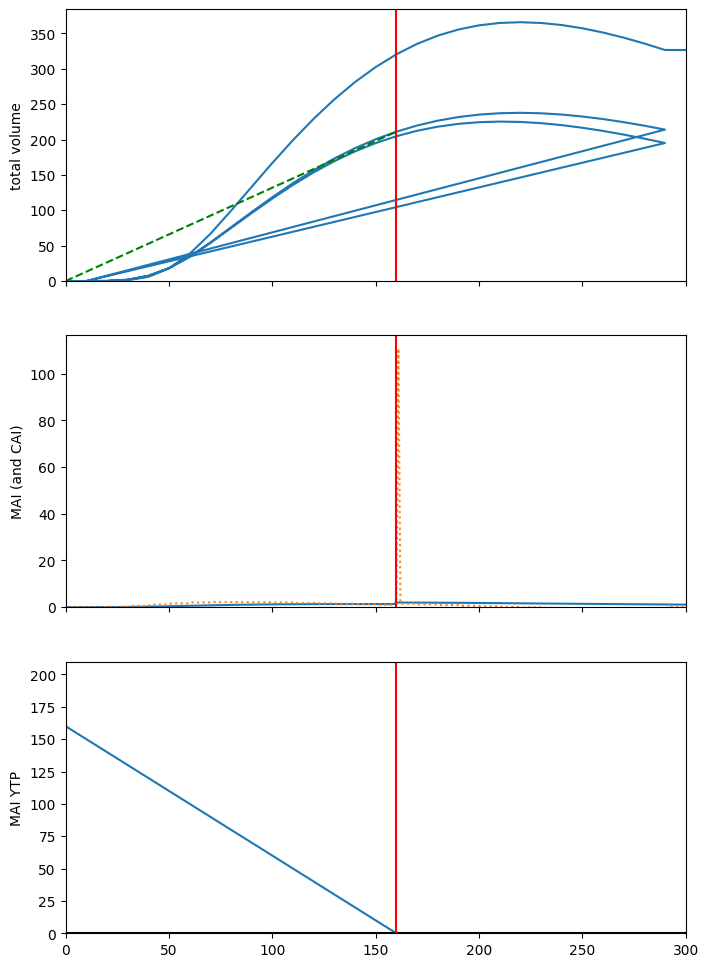

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [30]:
with open(woodstock_model_files_act_path, 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? _AGE >= 140 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [31]:
with open(woodstock_model_files_trn_path, 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme2 in record_au: continue
        if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?' , str(target_curve_id), '?', '?'))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id)))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme2)

In [32]:
stands_table = stands_mdf
curve_points_table = pd.read_csv("data/yldmerged_mmdf.csv")
curve_points_table.set_index('AU', inplace=True)

In [33]:
with open(woodstock_model_files_yld_path, 'w') as file:
    tot=[]
    swd=[]
    hwd=[]
    unique_au_rows = curve_points_table[~curve_points_table.index.duplicated(keep='first')]    
    for AU, au_row in unique_au_rows.iterrows():
        yname = 's%04d' % int(au_row.canfi_species)    
        curve_id = au_row.curve_id
        mask = ('?', '?', str(AU), '?', str(curve_id))
        points = [(r.age, r.volume) for _, r in curve_points_table.loc[AU].iterrows() if not r.age % period_length and r.age <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask), file=file)
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 300, 10)), file=file)
        if yname not in tot:
            tot.append(yname)
        if int(au_row.canfi_species) > 1200:
            if yname not in hwd: hwd.append(yname)
        else:
            if yname not in swd: swd.append(yname)
    print('*YC ? ? ? ? ?', file=file)
    print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
    print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
    print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

[(0.0, 9.0, 0.0, 0.0), (9.0, 10.0, 0.0, 0.000267552), (10.0, 20.0, 0.000267552, 4.03e-07), (20.0, 20.0, 4.03e-07, 0.05879367), (20.0, 30.0, 0.05879367, 0.00193475), (30.0, 30.0, 0.00193475, 0.7609025), (30.0, 40.0, 0.7609025, 0.070111701), (40.0, 40.0, 0.070111701, 3.665502029), (40.0, 50.0, 3.665502029, 0.596325309), (50.0, 50.0, 0.596325309, 10.61556461), (50.0, 60.0, 10.61556461, 2.498872773), (60.0, 60.0, 2.498872773, 22.55052768), (60.0, 70.0, 22.55052768, 6.873511865), (70.0, 70.0, 6.873511865, 38.72269924), (70.0, 80.0, 38.72269924, 14.27800533), (80.0, 80.0, 14.27800533, 57.87732798), (80.0, 90.0, 57.87732798, 24.36533191), (90.0, 90.0, 24.36533191, 78.82515872), (90.0, 100.0, 78.82515872, 35.89311491), (100.0, 100.0, 35.89311491, 100.4284657), (100.0, 110.0, 100.4284657, 48.08532097), (110.0, 110.0, 48.08532097, 121.6902694), (110.0, 120.0, 121.6902694, 60.27950516), (120.0, 120.0, 60.27950516, 141.7950228), (120.0, 130.0, 141.7950228, 71.94689203), (130.0, 130.0, 71.94689203,

ZeroDivisionError: float division by zero

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)